##Multi-layer LSTM for forecasting

Use the same RNN architecture, but stack `LSTM` layers instead of `SimpleRNN` layers

##Imports 

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

##Utilities

In [1]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

##Synthetic Data Utilities

In [3]:
def trend(time, slope=0):
  """
  Generate synthetic data that follows a straight line given a slope value

  Args:
    time (array of int) - contains the time steps
    slope (float) - determines the direction and steepness of the line

  Returns: 
    series (array of float) - measurements that follow a straight line
  """

  #Compute the linear given the slope 
  series = slope * time 

  return series 


def seasonal_pattern(season_time):
  """
  Just an arbitrary pattern that can be changed 

  Args:
    season_time (array of float) - contains the measurements per time step

  Returns:
    data_pattern (array of float) - contains revised measurement values according to the defined pattern
  """

  #Generates the values using arbitrary pattern 
  data_pattern = np.where(season_time < 0.4,
                          np.cos(season_time * 2 * np.pi),
                          1 / np.exp(3 * season_time))
  
  return data_pattern


def seasonality(time, period, amplitude=1, phase=0):
  """
  Repeats the same pattern at each period 

  Args:
    time (array of int) - contains the time steps 
    period (int) - number of time steps before the pattern repeats 
    amplitude (int) - number of time stps to shift the measured values 

  Returns:
    data_pattern (array of float) - seasonal data scaled by the defined amplitude
  """

  # Define the measured values per period 
  season_time = ((time + phase) % period) / period 

  # Generates the seasonal data scaled by the defined amplitude 
  data_pattern = amplitude * seasonal_pattern(season_time)

  return data_pattern


def noise(time, noise_level=1, seed=None):
  """
  Generates a normally distributed noisy signal 

  Args:
    time(array of int) - contains the time steps 
    noise_level (float) - scaling factor for the generated signal 
    seed (int) - number generator seed for repeatability 
  """

  #Intitialize the random number generator 
  rnd = np.random.RandomState(seed)

  #Generate a random number for each time step and scale by the noise level
  noise = rnd.randn(len(time)) * noise_level

  return noise

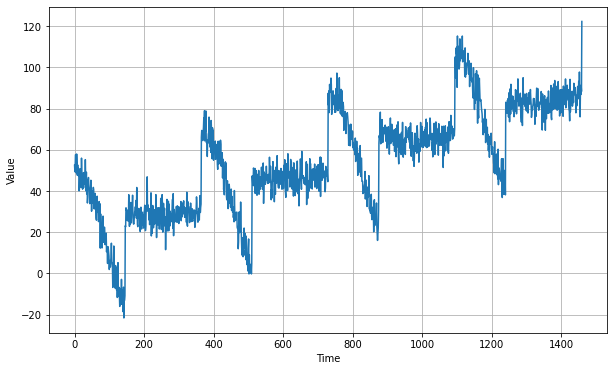

In [5]:
##Generate the synthetic data
time = np.arange(4 * 365 + 1, dtype='float32')
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

#Create the series 
series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

#Update with noise
series += noise(time, noise_level, seed=42)

#Plot the results 
plot_series(time, series)

##Split the dataset


In [9]:
#Define the split time 
split_time = 1000

#Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

#Get the validation set 
time_valid = time[split_time:]
x_valid = series[split_time:]

##Prepare the Features and Labels 

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """
  Generates dataset windows

  Args:
    series (array of float) - contains the values of the time series 
    window_size (int) - the number of time steps to include in the feature
    batch_size (int) - size of batches that will be fed into the model 
    shuffle_buffer (int) - buffer size to use for the shuffle method 

  Returns:
    dataset (TF Dataset) - TF Dataset containing time windows 
  """

  #Generate a TF Dataset from the series values 
  dataset = tf.data.Dataset.from_tensor_slices(series)

  #Window the data but only take those with the specified size 
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

  #Flatten the windows by putting elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  #Create tuples iwth features and labels 
  dataset = dataset.map(lambda window: (window[: -1], window[-1]))

  #Shuffle the windows
  dataset = dataset.shuffle(shuffle_buffer)

  #Create batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [11]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [12]:
#Generate the dataset windows 
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

##Build the Model

Swap the `SimpleRNN` for `LSTM` in this lab. 

It is also set as bidirectional.

LSTMs are much more complex in their internal architecture than simpleRNNs. They implement a cell state that allows it to remember sequences better than simple implementations. This added complexity results in a larger set of parameters to train 

In [16]:
#Build the model
model_tune = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1),
                             input_shape = [window_size]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model_tune.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 20, 1)             0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 20, 64)           8704      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
 lambda_5 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-trai

##Tune the learning rate

In [18]:
#Set the learning rate schedule 
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

#Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

#Set the training parameters 
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

#Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 9s 33ms/step - loss: 47.0824 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 30ms/step - loss: 45.8124 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 31ms/step - loss: 44.2891 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 30ms/step - loss: 42.5844 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 32ms/step - loss: 40.6814 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 31ms/step - loss: 38.5412 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 32ms/step - loss: 36.1218 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 34ms/step - loss: 33.3424 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 32ms/step - loss: 30.0708 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 1s 32ms/step - loss: 26.0779 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 30.0)

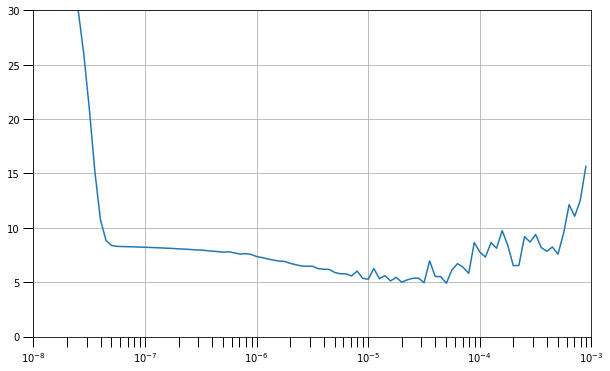

In [19]:
#Define the learning rate array
lrs = 1e-8 * (10**(np.arange(100) / 20))

#Set the figure size
plt.figure(figsize = (10,6))

#Set the grid
plt.grid(True)

#Plot the loss in log scale 
plt.semilogx(lrs, history.history['loss'])

#Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

#Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])

Zoom in

(1e-06, 1e-05, 0.0, 30.0)

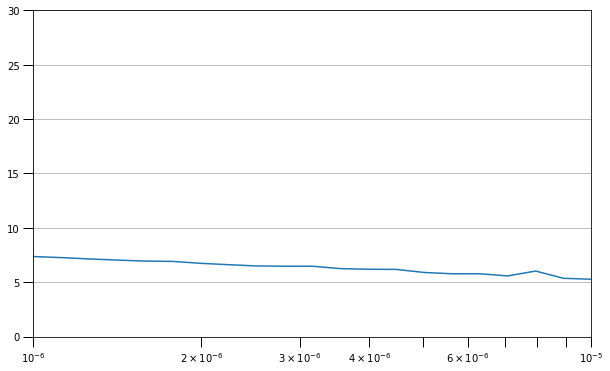

In [22]:
#Define the learning rate array
lrs = 1e-8 * (10**(np.arange(100) / 20))

#Set the figure size
plt.figure(figsize = (10,6))

#Set the grid
plt.grid(True)

#Plot the loss in log scale 
plt.semilogx(lrs, history.history['loss'])

#Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

#Set the plot boundaries
plt.axis([1e-6, 1e-5, 0, 30])

Looks like 6 x 10^-6 is optimal 

##Train the model 

In [25]:
#Reset the states generated by Keras
tf.keras.backend.clear_session()

#Build the model 
model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                             input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
])

#Set the learning rate 
learning_rate = 2e-6

#Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

#Set the training parameters 
model.compile(loss = tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics = ['mae'])

#Train the model
history = model.fit(dataset, epochs = 100)

Epoch 1/100
31/31 [==============================] - 10s 35ms/step - loss: 34.1609 - mae: 34.6586
Epoch 2/100
31/31 [==============================] - 1s 33ms/step - loss: 13.2765 - mae: 13.7664
Epoch 3/100
31/31 [==============================] - 1s 34ms/step - loss: 8.2170 - mae: 8.6974
Epoch 4/100
31/31 [==============================] - 1s 33ms/step - loss: 7.0539 - mae: 7.5351
Epoch 5/100
31/31 [==============================] - 1s 33ms/step - loss: 6.8136 - mae: 7.2951
Epoch 6/100
31/31 [==============================] - 1s 32ms/step - loss: 6.6172 - mae: 7.0996
Epoch 7/100
31/31 [==============================] - 1s 34ms/step - loss: 6.4030 - mae: 6.8810
Epoch 8/100
31/31 [==============================] - 1s 33ms/step - loss: 6.1930 - mae: 6.6749
Epoch 9/100
31/31 [==============================] - 1s 32ms/step - loss: 6.0443 - mae: 6.5217
Epoch 10/100
31/31 [==============================] - 1s 31ms/step - loss: 5.9984 - mae: 6.4789
Epoch 11/100
31/31 [========================

##Model Prediction

Generate batches of windows to create predictions that align with the validation set

In [26]:
def model_forecast(model, series, window_size, batch_size):
  """
  Uses an input model to generate predicitons on data windows 

  Args:
    model (TF Keras Model) - model that accepts data windows 
    series (array of float) - contains the values of the time series 
    window_size (int) - the number of time steps to include in the window 
    batch_size (int) - size of batches that are fed into model for predictions

  Returns:
    forecast (numpy array) - array containing predictions
  """

  #Generate a TF dataset form the series values 
  dataset = tf.data.Dataset.from_tensor_slices(series)

  #Window the data but only take those with the specified size
  dataset = dataset.window(window_size, shift=1, drop_remainder=True)

  #Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda w: w.batch(window_size))

  #Create batches of windows 
  dataset = dataset.batch(batch_size).prefetch(1)

  #Get predictions on the entire dataset
  forecast = model.predict(dataset)

  return forecast

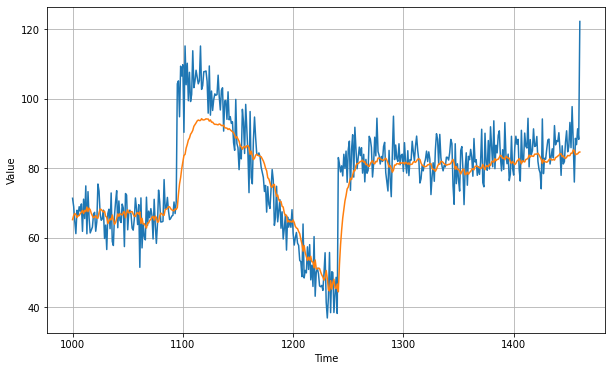

In [29]:
#Reduce the original series 
forecast_series = series[split_time-window_size: -1]

#Use model_forecast() function to generate predictions 
forecast = model_forecast(model, forecast_series, window_size, batch_size)

#Drop single dimensional axis 
results = forecast.squeeze()

#Plot the results 
plot_series(time_valid, (x_valid, results))

In [31]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

64.36489
5.722731
